# Anomaly Detection Homework

This notebook is for anomaly detection homework of Applied AI Week 2. The dataset is given with [this link](https://drive.google.com/file/d/1cZGOZu_zdKLXnH-Ap1w9SMffYXZqa2Ot/view?usp=sharing). If you are having problems with the link, contact with me: safakk.bilici.2112@gmail.com

## Dataset Description
"KDD CUP 99 data set is used mainly to analyze the different
attacks. It consists of nearly 4,900,000 samples with 41
features and each sample is classified as either normal or
attack" [explanation from this source](https://www.ripublication.com/ijaer18/ijaerv13n7_81.pdf)

## Task Description

I prepared dataset for anomaly detection task, the dataset contains "Probe" and "Normal" targets. "Probe" is anomaly, "Normal" is normal. 

You are supposed to build a anomaly detection model, which can be a single logistic regression, or a fancy state-of-the-art ensemble 1000B parameter model. It is really up to you. 

But of course, we don't really want you to do sloppy homework.

The variable descriptions:

- train set: kdd_train_probe
- validation set (for hyperparam tuning): kdd_valid_probe
- test set: kdd_test_v2_probe

## What will you report?
Report your average macro f1 score on test set:

```python
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred, average = "macro")
print(f1)
```

## About Notebook's Solution

I implemented 4 different autoencoder model as a solution, since we didn't make such experiments on autoencoders.

- Vanilla Autoencoder
- Variational Autoencoder
- Denoising Autoencoder
- Ensemble Autoencoders


# Preparation (do not edit this part)

In [111]:
import pandas as pd
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning

import torch.nn as nn
import torch
import sys
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from collections import defaultdict
from tqdm.auto import tqdm

import seaborn as sns
from pylab import rcParams

from sklearn.metrics import f1_score, accuracy_score, classification_report

In [112]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 10, 4

In [2]:

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

kdd = pd.read_csv('/content/drive/MyDrive/applied_ai_enes_safak/homework/kdd.csv')
kdd = kdd.iloc[:,1:43]
kdd = kdd.drop(['Protocol Type', 'Service', 'Flag'], axis = 1)

kdd_train = kdd.iloc[0:102563, :]
kdd_test = kdd.iloc[102563:183737, :]

kdd_train_probe = kdd_train[(kdd_train.Type_Groups == 'Normal') | (kdd_train.Type_Groups == 'Probe')]
kdd_test_probe = kdd_test[(kdd_test.Type_Groups == 'Normal') | (kdd_test.Type_Groups == 'Probe')]

kdd_train_probe['Type_Groups'] = np.where(kdd_train_probe['Type_Groups'] == 'Normal', 0, 1)
kdd_test_probe['Type_Groups'] = np.where(kdd_test_probe['Type_Groups'] == 'Normal', 0, 1)

kdd_valid_probe = kdd_test_probe.iloc[14000:34000,:]
kdd_test_v2_probe = pd.concat([kdd_test_probe.iloc[0:14000,:], kdd_test_probe.iloc[34001:64759,:]])


# classify anomalies and normals
# train set: kdd_train_probe
# validation set (for hyperparam tuning): kdd_valid_probe
# test set: kdd_test_v2_probe
# avg. macro f1 score on test set

## Pytorch DataLoaders

In [74]:
# create our dataloaders for train set and val set
# we will use autoencoders to detect anomalies, so we dont need anomaly class
# remove anomaly samples and train autoencoder to learn reconstruction of normal samples

BATCH_SIZE = 128

train_normal = kdd_train_probe[kdd_train_probe.Type_Groups == 0]
val_normal = kdd_valid_probe[kdd_valid_probe.Type_Groups == 0]
test_normal = kdd_test_v2_probe[kdd_test_v2_probe.Type_Groups == 0]

train_data = TensorDataset(torch.Tensor(train_normal.iloc[:,:-1].to_numpy()))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(torch.Tensor(val_normal.iloc[:,:-1].to_numpy()))
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

[0 1] [0 1] [0 1]


# VAE

In [63]:
# VAE implementation in PyTorch

class LinearVAE(nn.Module):
    def __init__(self, n_features, latent_dim):
        super(LinearVAE, self).__init__()
        self.n_features = n_features

        self.encoder = nn.Sequential(
            nn.Linear(n_features, 20),
            nn.Tanh()
        )

        self.encoder2mean = nn.Linear(20, latent_dim)
        self.encoder2logvar = nn.Linear(20, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 20),
            nn.ReLU(),
            nn.Linear(20, n_features)
        )
    
    def forward(self, x):
        bs = x.size(0)
        out = self.encoder(x)
        
        mu = self.encoder2mean(out)
        log_var = self.encoder2logvar(out)

        z = self.reparameterize(mu, log_var)

        out = self.decoder(z)
        return out, mu, log_var
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample

In [64]:
def evaluate(model, criterion, val_dataloader, device):
    total = len(val_dataloader)
    print("Evaluating...")
    loss_a = []
    with tqdm(total = total, leave=False) as ee:
        val_loss, val_batch_loss, val_batch_counts = 0, 0, 0
        for step, batch in enumerate(val_dataloader):
            model.eval()
            val_batch_loss += 1
            b_inputs, = tuple(t.to(device) for t in batch)
      
            with torch.no_grad():
                out, mu, log_var = model.forward(b_inputs)
            
            recloss = criterion(out, b_inputs) # NLL loss
            kld = (-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())) / b_inputs.size(0) # KL divergence loss
            loss = (recloss + kld) / 2

            loss_a.append(loss.detach().cpu().numpy())

            ee.update()
    return np.mean(loss_a)

In [69]:
def train(model, optimizer, criterion, train_dataloader, val_dataloader, device, EPOCHS):
    model = model.to(device)
    total = len(train_dataloader) * EPOCHS
    log = defaultdict(list)
    log["train_loss"] = []
    log["eval_loss"] = []
    loss_a = []

    with tqdm(total = total) as tt:
        for epoch in range(EPOCHS):
            kl, nll, total_loss, batch_loss, batch_counts = 0, 0, 0, 0, 0
            for step, batch in enumerate(train_dataloader):
                model.train()
                batch_counts +=1

                b_inputs, = tuple(t.to(device) for t in batch)
                optimizer.zero_grad()

                out, mu, log_var = model.forward(b_inputs)

                recloss = criterion(out, b_inputs)

                kld = (-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()))
                loss = (recloss + kld) / 2
                loss.backward()

                optimizer.step()

                batch_loss += loss.item()
                total_loss += loss.item()
                nll += recloss.item()
                kl += kld.item()
                tt.update()

            val_loss = evaluate(model, criterion, val_dataloader, device)
            print(30*"-")
            print(f"{epoch+1}/{EPOCHS}")
            print(f"train loss: {batch_loss / batch_counts}, val loss: {val_loss}")
            print(f"train nll loss: {nll / batch_counts}, train kl loss: {kl / batch_counts}")
            log["train_loss"].append(batch_loss / batch_counts)
            log["eval_loss"].append(val_loss)
            

            if log["eval_loss"][np.argmin(log["eval_loss"])] == val_loss:
                print(f"Best model is stored with eval loss {val_loss}.")
                best_model = model
            print(30*"-")
    return model, best_model, log

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearVAE(train_normal.shape[1] - 1, 10)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

criterion = torch.nn.L1Loss(reduction="sum")
EPOCHS = 125


In [71]:
model, best_model, log = train(
    model, 
    optimizer, 
    criterion, 
    train_dataloader, 
    val_dataloader, 
    device, 
    EPOCHS
)

  0%|          | 0/95000 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
1/125
train loss: 517.3989891453793, val loss: 343.2962341308594
train nll loss: 1024.4111627679122, train kl loss: 10.386815802831398
Best model is stored with eval loss 343.2962341308594.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
2/125
train loss: 395.48001331530116, val loss: 341.9048156738281
train nll loss: 787.9858889931127, train kl loss: 2.9741367154999785
Best model is stored with eval loss 341.9048156738281.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
3/125
train loss: 390.57152930811833, val loss: 335.84967041015625
train nll loss: 768.5756408691407, train kl loss: 12.567417890147158
Best model is stored with eval loss 335.84967041015625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
4/125
train loss: 389.2508775008352, val loss: 334.9661560058594
train nll loss: 761.459468801398, train kl loss: 17.042285225265903
Best model is stored with eval loss 334.9661560058594.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
5/125
train loss: 388.52196896201684, val loss: 333.297607421875
train nll loss: 758.2289779663085, train kl loss: 18.814959327798142
Best model is stored with eval loss 333.297607421875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
6/125
train loss: 387.62930743568825, val loss: 330.4679260253906
train nll loss: 754.1285019723992, train kl loss: 21.130112304185566
Best model is stored with eval loss 330.4679260253906.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
7/125
train loss: 386.396543924432, val loss: 326.1188659667969
train nll loss: 747.3276769537674, train kl loss: 25.465410917683652
Best model is stored with eval loss 326.1188659667969.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
8/125
train loss: 385.4340936761153, val loss: 325.08233642578125
train nll loss: 740.6813866866262, train kl loss: 30.186800382011814
Best model is stored with eval loss 325.08233642578125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
9/125
train loss: 384.6333095349764, val loss: 324.9253845214844
train nll loss: 737.075764063785, train kl loss: 32.190855304818406
Best model is stored with eval loss 324.9253845214844.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
10/125
train loss: 384.35455583271226, val loss: 323.0830078125
train nll loss: 734.8258822792454, train kl loss: 33.88322985297755
Best model is stored with eval loss 323.0830078125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
11/125
train loss: 383.72811086554276, val loss: 321.6950988769531
train nll loss: 732.7249754253187, train kl loss: 34.7312464739147
Best model is stored with eval loss 321.6950988769531.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
12/125
train loss: 383.1961898803711, val loss: 322.0823669433594
train nll loss: 730.7823306435033, train kl loss: 35.61004900430378
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
13/125
train loss: 382.6213033977308, val loss: 322.4990539550781
train nll loss: 728.3464463083368, train kl loss: 36.89616054233752
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
14/125
train loss: 382.40378397891396, val loss: 321.6758728027344
train nll loss: 726.7250098379035, train kl loss: 38.082557718377366
Best model is stored with eval loss 321.6758728027344.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
15/125
train loss: 381.96598362169766, val loss: 324.3314208984375
train nll loss: 725.5155125266627, train kl loss: 38.41645474182932
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
16/125
train loss: 382.02561404579563, val loss: 323.0809020996094
train nll loss: 725.1689120644018, train kl loss: 38.88231726696617
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
17/125
train loss: 381.98750762939454, val loss: 323.3567810058594
train nll loss: 725.0749114990234, train kl loss: 38.90010320763839
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
18/125
train loss: 381.8581751371685, val loss: 323.063232421875
train nll loss: 725.101643371582, train kl loss: 38.614706732097424
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
19/125
train loss: 381.87442221390575, val loss: 323.1185607910156
train nll loss: 724.4136524401213, train kl loss: 39.33519268035889
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
20/125
train loss: 381.7320493597733, val loss: 323.5647277832031
train nll loss: 724.4531903718647, train kl loss: 39.010908598648875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
21/125
train loss: 381.9174773768375, val loss: 324.2703552246094
train nll loss: 724.4621409366006, train kl loss: 39.37281400278995
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
22/125
train loss: 381.8339604829487, val loss: 323.1840515136719
train nll loss: 723.8624637804534, train kl loss: 39.805455378482215
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
23/125
train loss: 382.0290698001259, val loss: 323.12481689453125
train nll loss: 724.4982346785696, train kl loss: 39.55990513249448
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
24/125
train loss: 381.69991296467026, val loss: 323.8437194824219
train nll loss: 723.9794910230135, train kl loss: 39.42033539320293
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
25/125
train loss: 381.6495394656533, val loss: 323.92547607421875
train nll loss: 723.915329702277, train kl loss: 39.38374889273393
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
26/125
train loss: 381.9205040379574, val loss: 323.405517578125
train nll loss: 724.4257170827765, train kl loss: 39.41529139468545
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
27/125
train loss: 381.67837436073705, val loss: 324.5541076660156
train nll loss: 723.6488046746505, train kl loss: 39.70794341940629
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
28/125
train loss: 381.81781885247483, val loss: 323.6180419921875
train nll loss: 724.4172288191946, train kl loss: 39.218408258337725
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
29/125
train loss: 381.6020272907458, val loss: 323.393798828125
train nll loss: 723.6800980818899, train kl loss: 39.52395670037521
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
30/125
train loss: 381.7609576576634, val loss: 323.29071044921875
train nll loss: 724.1165351466128, train kl loss: 39.40538165945756
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
31/125
train loss: 381.8515077289782, val loss: 322.9696044921875
train nll loss: 723.5994256270559, train kl loss: 40.10358984093917
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
32/125
train loss: 381.86154809249075, val loss: 324.3479919433594
train nll loss: 724.1575000963713, train kl loss: 39.56559585772062
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
33/125
train loss: 381.95403651187297, val loss: 324.1039123535156
train nll loss: 724.2691538760537, train kl loss: 39.63891861062301
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
34/125
train loss: 381.72610634251646, val loss: 323.47332763671875
train nll loss: 723.8853619224146, train kl loss: 39.56685136995817
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
35/125
train loss: 381.8436144377056, val loss: 323.46923828125
train nll loss: 723.2679089997944, train kl loss: 40.41931886672974
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
36/125
train loss: 381.8385314138312, val loss: 323.8760986328125
train nll loss: 723.3901901245117, train kl loss: 40.286873119755796
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
37/125
train loss: 381.8364454169022, val loss: 323.9725646972656
train nll loss: 723.8618934229801, train kl loss: 39.81099836951808
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
38/125
train loss: 381.9235863535028, val loss: 323.2620849609375
train nll loss: 723.7635351883738, train kl loss: 40.083637754540696
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
39/125
train loss: 381.84169343647204, val loss: 322.7596130371094
train nll loss: 723.7723944413035, train kl loss: 39.91099319458008
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
40/125
train loss: 381.5715093110737, val loss: 324.196044921875
train nll loss: 723.5542463603773, train kl loss: 39.588772532814424
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
41/125
train loss: 381.6467256646407, val loss: 324.0774230957031
train nll loss: 723.6238749453896, train kl loss: 39.669578135641
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
42/125
train loss: 381.9152030543277, val loss: 324.48236083984375
train nll loss: 724.0023157220138, train kl loss: 39.82808901636224
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
43/125
train loss: 381.83580069290963, val loss: 324.2838134765625
train nll loss: 724.081451496325, train kl loss: 39.59015080301385
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
44/125
train loss: 381.86296796296773, val loss: 323.5568542480469
train nll loss: 723.7188743591308, train kl loss: 40.00706217916388
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
45/125
train loss: 381.3971335160105, val loss: 323.2693786621094
train nll loss: 723.0134264092696, train kl loss: 39.78084093896966
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
46/125
train loss: 381.62951278686523, val loss: 324.02252197265625
train nll loss: 723.5348524394789, train kl loss: 39.72417349062468
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
47/125
train loss: 381.7419164557206, val loss: 324.6418151855469
train nll loss: 723.751361003675, train kl loss: 39.732471195020175
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
48/125
train loss: 381.82888059114157, val loss: 323.7433166503906
train nll loss: 723.5365488955849, train kl loss: 40.1212121963501
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
49/125
train loss: 382.0751501384534, val loss: 323.0293884277344
train nll loss: 723.8354858398437, train kl loss: 40.31481332778931
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
50/125
train loss: 381.81542490908976, val loss: 324.0740661621094
train nll loss: 723.3031491329796, train kl loss: 40.32770038905897
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
51/125
train loss: 381.8006118774414, val loss: 324.1401062011719
train nll loss: 723.2882205360814, train kl loss: 40.31300256126806
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
52/125
train loss: 381.7424281070107, val loss: 324.6064453125
train nll loss: 723.1998221949527, train kl loss: 40.28503419976485
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
53/125
train loss: 381.65303786428353, val loss: 323.2250671386719
train nll loss: 723.6194150422749, train kl loss: 39.68666107780055
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
54/125
train loss: 381.63141680265727, val loss: 325.63201904296875
train nll loss: 723.3501332333213, train kl loss: 39.912701576634454
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
55/125
train loss: 381.51453363518965, val loss: 323.9359436035156
train nll loss: 723.4249323794717, train kl loss: 39.604133636073065
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
56/125
train loss: 381.9072296544125, val loss: 322.7749938964844
train nll loss: 723.5750916330438, train kl loss: 40.23936767578125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
57/125
train loss: 381.8834029348273, val loss: 323.4893493652344
train nll loss: 723.6713470458984, train kl loss: 40.095458708311384
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
58/125
train loss: 381.7711808455618, val loss: 323.6338806152344
train nll loss: 723.480495573345, train kl loss: 40.061865957159746
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7f697f76b5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1152, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


------------------------------
59/125
train loss: 381.6723950837788, val loss: 324.33868408203125
train nll loss: 723.2649752968236, train kl loss: 40.0798144842449
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
60/125
train loss: 381.832224574842, val loss: 323.44110107421875
train nll loss: 723.3956011721963, train kl loss: 40.268846958561944
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
61/125
train loss: 381.5330164056075, val loss: 323.60626220703125
train nll loss: 723.0932165848582, train kl loss: 39.97281500163831
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
62/125
train loss: 381.97559296457393, val loss: 323.527587890625
train nll loss: 723.668694706967, train kl loss: 40.28249088588514
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
63/125
train loss: 381.721052350496, val loss: 324.478515625
train nll loss: 723.5529875102796, train kl loss: 39.88911730615716
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
64/125
train loss: 381.62805589374744, val loss: 324.7428283691406
train nll loss: 723.7469076859323, train kl loss: 39.50920434249075
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
65/125
train loss: 381.63846347206515, val loss: 323.2803955078125
train nll loss: 723.3124128241288, train kl loss: 39.96451398949874
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
66/125
train loss: 381.91106370624743, val loss: 323.9007568359375
train nll loss: 723.4064933375308, train kl loss: 40.41563386415181
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
67/125
train loss: 381.5574897766113, val loss: 323.489013671875
train nll loss: 723.1502829702277, train kl loss: 39.96469676871049
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
68/125
train loss: 381.5222167165656, val loss: 323.0876770019531
train nll loss: 723.4699683741519, train kl loss: 39.57446550570036
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
69/125
train loss: 381.62417795281664, val loss: 324.4878845214844
train nll loss: 723.5876337954872, train kl loss: 39.66072162828947
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
70/125
train loss: 381.8092491952996, val loss: 324.55755615234375
train nll loss: 723.2391665810032, train kl loss: 40.379332251297804
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
71/125
train loss: 381.6412272001568, val loss: 324.1939392089844
train nll loss: 723.704056027061, train kl loss: 39.57839812228554
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
72/125
train loss: 381.68272357739903, val loss: 325.0033874511719
train nll loss: 723.4618947882401, train kl loss: 39.903552100532934
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
73/125
train loss: 381.5232842294793, val loss: 325.6901550292969
train nll loss: 723.518254571212, train kl loss: 39.52831356148971
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
74/125
train loss: 381.9183798137464, val loss: 324.5630798339844
train nll loss: 723.3492977744654, train kl loss: 40.48746053294131
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
75/125
train loss: 381.97728008471034, val loss: 324.3772888183594
train nll loss: 724.0195837322034, train kl loss: 39.93497610092163
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
76/125
train loss: 381.64292827405427, val loss: 323.7070617675781
train nll loss: 723.3540771082828, train kl loss: 39.931778701983
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
77/125
train loss: 381.45614158228824, val loss: 324.6216125488281
train nll loss: 723.4419402674624, train kl loss: 39.47034439789621
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
78/125
train loss: 381.8653513858193, val loss: 323.3797607421875
train nll loss: 723.4180737947163, train kl loss: 40.312628454911085
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
79/125
train loss: 381.7082464920847, val loss: 324.2558898925781
train nll loss: 723.0136342098839, train kl loss: 40.40285829242907
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
80/125
train loss: 381.41110602930974, val loss: 324.1711730957031
train nll loss: 723.2723037719727, train kl loss: 39.54990894418014
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
81/125
train loss: 381.7912292078922, val loss: 325.2838439941406
train nll loss: 723.1994591160825, train kl loss: 40.38299933483726
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
82/125
train loss: 381.8967789499383, val loss: 325.14764404296875
train nll loss: 723.5029141877827, train kl loss: 40.29064429935656
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
83/125
train loss: 381.5092461033871, val loss: 324.9770812988281
train nll loss: 723.0999433818616, train kl loss: 39.9185485086943
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
84/125
train loss: 381.5164365266499, val loss: 324.3115234375
train nll loss: 723.3499201322857, train kl loss: 39.682951706334165
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
85/125
train loss: 381.5590825934159, val loss: 324.9553527832031
train nll loss: 723.2040928890831, train kl loss: 39.91407405953658
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
86/125
train loss: 381.6205519425242, val loss: 325.184326171875
train nll loss: 723.0899799547698, train kl loss: 40.151122484709084
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
87/125
train loss: 381.6084207635177, val loss: 324.0825500488281
train nll loss: 723.0016162269994, train kl loss: 40.215225771853795
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
88/125
train loss: 381.53753352918125, val loss: 325.4122619628906
train nll loss: 722.9284649899131, train kl loss: 40.146602234087496
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
89/125
train loss: 381.4959683468467, val loss: 325.306396484375
train nll loss: 722.8900062962582, train kl loss: 40.10193002600419
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
90/125
train loss: 381.73016895494965, val loss: 326.2016906738281
train nll loss: 723.0187491969058, train kl loss: 40.44158912457918
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
91/125
train loss: 381.6863075256348, val loss: 324.9135437011719
train nll loss: 723.3390712537264, train kl loss: 40.033543566653606
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
92/125
train loss: 381.7498179787084, val loss: 324.4091796875
train nll loss: 723.7145905745657, train kl loss: 39.78504580447548
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
93/125
train loss: 381.5614465813888, val loss: 325.3786315917969
train nll loss: 722.6772983751799, train kl loss: 40.44559562582719
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
94/125
train loss: 381.83946284243933, val loss: 324.3858642578125
train nll loss: 723.1769081918817, train kl loss: 40.50201615283364
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
95/125
train loss: 381.49289631090664, val loss: 325.4915466308594
train nll loss: 723.3430455258018, train kl loss: 39.64274797439575
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
96/125
train loss: 381.624080376876, val loss: 323.9688720703125
train nll loss: 723.0315830431487, train kl loss: 40.2165774746945
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
97/125
train loss: 381.4799785011693, val loss: 324.2322998046875
train nll loss: 722.9454614739669, train kl loss: 40.0144946801035
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
98/125
train loss: 381.5078315333316, val loss: 325.3770751953125
train nll loss: 723.1777674223247, train kl loss: 39.83789628681384
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
99/125
train loss: 381.71354526720546, val loss: 324.52215576171875
train nll loss: 722.9351690995065, train kl loss: 40.49192158046522
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
100/125
train loss: 381.53105344270404, val loss: 325.45672607421875
train nll loss: 723.7699819464433, train kl loss: 39.29212479340403
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
101/125
train loss: 381.5231766750938, val loss: 324.8516540527344
train nll loss: 722.8906107450787, train kl loss: 40.15574238927741
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
102/125
train loss: 381.953136966103, val loss: 324.3226013183594
train nll loss: 723.5990751969186, train kl loss: 40.30719907158299
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
103/125
train loss: 381.6888139022024, val loss: 325.1947326660156
train nll loss: 722.9383030941611, train kl loss: 40.439325262370865
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
104/125
train loss: 381.5135607669228, val loss: 324.77337646484375
train nll loss: 722.5445045872739, train kl loss: 40.482617679395176
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
105/125
train loss: 381.7402962935598, val loss: 324.72662353515625
train nll loss: 723.6071836772718, train kl loss: 39.8734095924779
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
106/125
train loss: 381.8209568626002, val loss: 323.7679748535156
train nll loss: 722.7846553601717, train kl loss: 40.85725901754279
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
107/125
train loss: 381.67950443468595, val loss: 325.4721984863281
train nll loss: 722.8416200738204, train kl loss: 40.51738876543547
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
108/125
train loss: 381.6331104479338, val loss: 324.177734375
train nll loss: 722.9256427965666, train kl loss: 40.34057656840274
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
109/125
train loss: 381.7043994301244, val loss: 325.2592468261719
train nll loss: 722.5965815092388, train kl loss: 40.81221720544915
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
110/125
train loss: 381.6760333412572, val loss: 324.4789123535156
train nll loss: 722.9242107190584, train kl loss: 40.42785527078729
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
111/125
train loss: 381.5452715020431, val loss: 325.5794677734375
train nll loss: 722.8895086589613, train kl loss: 40.20103433508622
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
112/125
train loss: 381.74472367136104, val loss: 324.8077697753906
train nll loss: 722.8771759033203, train kl loss: 40.61227088727449
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
113/125
train loss: 381.70015728599145, val loss: 324.659423828125
train nll loss: 722.8021555047286, train kl loss: 40.59815956416883
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
114/125
train loss: 381.48211268374797, val loss: 325.0455322265625
train nll loss: 723.1196265772769, train kl loss: 39.84459904118588
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
115/125
train loss: 381.8639907435367, val loss: 325.15863037109375
train nll loss: 722.5564270421079, train kl loss: 41.17155591563174
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
116/125
train loss: 381.56887178922955, val loss: 323.5778503417969
train nll loss: 722.3170026678788, train kl loss: 40.82074088046425
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
117/125
train loss: 381.3835849561189, val loss: 326.0073547363281
train nll loss: 722.3274880660208, train kl loss: 40.439681946603876
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
118/125
train loss: 381.6803491291247, val loss: 325.05230712890625
train nll loss: 723.617446497867, train kl loss: 39.74325173026637
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
119/125
train loss: 381.74892152485097, val loss: 325.1947326660156
train nll loss: 722.9168408444053, train kl loss: 40.58100346013119
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
120/125
train loss: 381.6146328775506, val loss: 323.673828125
train nll loss: 723.1521909613358, train kl loss: 40.07707557678223
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
121/125
train loss: 381.67501622250205, val loss: 326.09326171875
train nll loss: 722.9003052560906, train kl loss: 40.449727224048814
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
122/125
train loss: 381.4485268040707, val loss: 324.7181701660156
train nll loss: 722.7207971673263, train kl loss: 40.17625660645334
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
123/125
train loss: 381.74082621524207, val loss: 326.3525085449219
train nll loss: 723.1684396041067, train kl loss: 40.31321308236373
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
124/125
train loss: 381.2616625534861, val loss: 326.09930419921875
train nll loss: 722.6610747086374, train kl loss: 39.86225108096474
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
125/125
train loss: 381.68502032631324, val loss: 324.4825744628906
train nll loss: 723.1610765959088, train kl loss: 40.20896421733656
------------------------------


In [80]:
def thresholding(model, criterion, dataset, device):
    preds, losses = [], []
    total = len(dataset)

    val_data = TensorDataset(torch.Tensor(dataset.iloc[:,:-1].to_numpy()))
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=1)
    with tqdm(total = total) as ee:
        with torch.no_grad():
            for step, batch in enumerate(val_dataloader):
                model.eval()
                b_inputs, = tuple(t.to(device) for t in batch)
                out, mu, log_var = model.forward(b_inputs)

                nll = criterion(out, b_inputs)
                kld = (-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()))

                loss = (nll + kld) / 2

                preds.append([out.detach().cpu().numpy(), b_inputs.cpu().numpy()])
                losses.append(loss.detach().cpu().numpy())
                ee.update()
            ee.close()

    return preds, losses

In [81]:
reconstructions, losses = thresholding(best_model, criterion, test_normal, device)

  0%|          | 0/41836 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


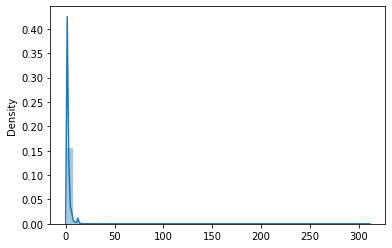

In [82]:
sns.distplot(losses, bins=50, kde=True);

In [83]:
threshold = np.mean(losses)
print(threshold)

2.7633643


In [91]:
def torch_classification_report(model, criterion, df_all, device, threshold, print_report = True, disable=False):
    all_data = TensorDataset(torch.tensor(df_all.iloc[:,:-1].to_numpy()), torch.tensor(df_all.Type_Groups.to_numpy()))
    all_sampler = SequentialSampler(all_data)
    all_dataloader = DataLoader(all_data, sampler=all_sampler, batch_size=1)
    total = len(all_dataloader)
    preds = []
    targets = []

    with tqdm(total = total, disable=disable) as ee:
        with torch.no_grad():
            for step, batch in enumerate(all_dataloader):
                model.eval()
                b_inputs, b_targets = tuple(t.to(device) for t in batch)
                out, mu, log_var = model.forward(b_inputs.float())
                
                nll = criterion(out, b_inputs)
                kld = (-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()))

                loss = (nll + kld) / 2

                targets.append(b_targets.item())

                if loss> threshold:
                    preds.append(1)
                else:
                    preds.append(0)
                ee.update()

    f1 = f1_score(targets, preds)
    acc = accuracy_score(targets, preds)
    if print_report:
        print(classification_report(targets, preds))
    return acc, f1

In [93]:
acc, f1 = torch_classification_report(best_model, criterion, kdd_test_v2_probe, device, threshold, print_report = True, disable=False)

# i didnt play with hyperparameters
# i think vae is not a good solution for this dataset
# you can play with hyperparameters: 
# e.g. interpolating the threshold space by looking validation set, as we will do in other models

  0%|          | 0/44758 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.76      0.86     41836
           1       0.23      1.00      0.37      2922

    accuracy                           0.78     44758
   macro avg       0.61      0.88      0.62     44758
weighted avg       0.95      0.78      0.83     44758



# Vanilla AE

In [98]:
# Linear autoencoder implementation in PyTorch
class VanillaAE(nn.Module):
    def __init__(self, n_features, latent_dim):
        super(VanillaAE, self).__init__()
        self.n_features = n_features

        self.encoder = nn.Sequential(
            nn.Linear(n_features, 20),
            nn.Tanh(),
            nn.Linear(20, latent_dim),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 20),
            nn.ReLU(),
            nn.Linear(20, n_features)
        )
    
    def forward(self, x):
        bs = x.size(0)
        out = self.encoder(x)
        out = self.decoder(out)
        return out

# this implementation is less complicated
# you can add fancy layers, residual connections, dropout layers etc.

In [103]:
def evaluate(model, criterion, val_dataloader, device):
    total = len(val_dataloader)
    print("Evaluating...")
    loss_a = []
    with tqdm(total = total, leave=False) as ee:
        val_loss, val_batch_loss, val_batch_counts = 0, 0, 0
        for step, batch in enumerate(val_dataloader):
            model.eval()
            val_batch_loss += 1
            b_inputs, = tuple(t.to(device) for t in batch)
      
            with torch.no_grad():
                out = model.forward(b_inputs)
            
            loss = criterion(out, b_inputs)
            loss_a.append(loss.detach().cpu().numpy())

            ee.update()
    return np.mean(loss_a)

In [104]:
def train(model, optimizer, criterion, train_dataloader, val_dataloader, device, EPOCHS):
    model = model.to(device)
    total = len(train_dataloader) * EPOCHS
    log = defaultdict(list)
    log["train_loss"] = []
    log["eval_loss"] = []
    loss_a = []

    with tqdm(total = total) as tt:
        for epoch in range(EPOCHS):
            kl, nll, total_loss, batch_loss, batch_counts = 0, 0, 0, 0, 0
            for step, batch in enumerate(train_dataloader):
                model.train()
                batch_counts +=1

                b_inputs, = tuple(t.to(device) for t in batch)
                optimizer.zero_grad()

                out = model.forward(b_inputs)

                loss = criterion(out, b_inputs)
                loss.backward()

                optimizer.step()

                batch_loss += loss.item()
                total_loss += loss.item()
                tt.update()

            val_loss = evaluate(model, criterion, val_dataloader, device)
            print(30*"-")
            print(f"{epoch+1}/{EPOCHS}")
            print(f"train loss: {batch_loss / batch_counts}, val loss: {val_loss}")
            log["train_loss"].append(batch_loss / batch_counts)
            log["eval_loss"].append(val_loss)
            
            if log["eval_loss"][np.argmin(log["eval_loss"])] == val_loss:
                print(f"Best model is stored with eval loss {val_loss}.")
                best_model = model
            print(30*"-")
    return model, best_model, log

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VanillaAE(train_normal.shape[1] - 1, 10)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

criterion = torch.nn.L1Loss(reduction="sum")
EPOCHS = 125

# you can optimize the learning rate, or the optimizer in general
# it is not a willful loss function decision, you can choose more proper loss function
# for you dataset (depends on your dataset's characteristics)
# reduction="sum" parameter can be "mean". I like large gradient magnitudes lol

In [106]:
model, best_model, log = train(
    model, 
    optimizer, 
    criterion, 
    train_dataloader, 
    val_dataloader, 
    device, 
    EPOCHS
)

  0%|          | 0/95000 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
1/125
train loss: 745.6029119792737, val loss: 611.1862182617188
Best model is stored with eval loss 611.1862182617188.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
2/125
train loss: 476.1530837209601, val loss: 492.5682373046875
Best model is stored with eval loss 492.5682373046875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
3/125
train loss: 378.5578208521793, val loss: 476.63763427734375
Best model is stored with eval loss 476.63763427734375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
4/125
train loss: 356.68036175778036, val loss: 475.2370300292969
Best model is stored with eval loss 475.2370300292969.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
5/125
train loss: 348.5706002285606, val loss: 466.10443115234375
Best model is stored with eval loss 466.10443115234375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
6/125
train loss: 338.7304346787302, val loss: 436.122314453125
Best model is stored with eval loss 436.122314453125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
7/125
train loss: 314.26883667393736, val loss: 399.5955505371094
Best model is stored with eval loss 399.5955505371094.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
8/125
train loss: 305.39086414136386, val loss: 398.8094177246094
Best model is stored with eval loss 398.8094177246094.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
9/125
train loss: 303.6075695439389, val loss: 398.7768249511719
Best model is stored with eval loss 398.7768249511719.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
10/125
train loss: 300.0271060341283, val loss: 386.28546142578125
Best model is stored with eval loss 386.28546142578125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
11/125
train loss: 274.33653445996737, val loss: 377.0496826171875
Best model is stored with eval loss 377.0496826171875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
12/125
train loss: 262.15929987054125, val loss: 376.3890686035156
Best model is stored with eval loss 376.3890686035156.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
13/125
train loss: 259.0827271310907, val loss: 378.3146667480469
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
14/125
train loss: 257.3095085144043, val loss: 380.1273498535156
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
15/125
train loss: 256.0267671083149, val loss: 378.06927490234375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
16/125
train loss: 255.06502822072883, val loss: 378.0400390625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
17/125
train loss: 254.12129171271073, val loss: 376.13818359375
Best model is stored with eval loss 376.13818359375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
18/125
train loss: 253.38490030389082, val loss: 374.8471374511719
Best model is stored with eval loss 374.8471374511719.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
19/125
train loss: 252.66866685967696, val loss: 372.81829833984375
Best model is stored with eval loss 372.81829833984375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
20/125
train loss: 252.0335794750013, val loss: 373.75494384765625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
21/125
train loss: 251.27336488021047, val loss: 371.9747009277344
Best model is stored with eval loss 371.9747009277344.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
22/125
train loss: 250.54970169067383, val loss: 368.8994445800781
Best model is stored with eval loss 368.8994445800781.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
23/125
train loss: 249.40637482091, val loss: 366.9019470214844
Best model is stored with eval loss 366.9019470214844.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
24/125
train loss: 247.99417479665655, val loss: 363.9561462402344
Best model is stored with eval loss 363.9561462402344.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
25/125
train loss: 246.0893601467735, val loss: 359.44134521484375
Best model is stored with eval loss 359.44134521484375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
26/125
train loss: 243.828611012509, val loss: 356.36480712890625
Best model is stored with eval loss 356.36480712890625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
27/125
train loss: 240.94166353125323, val loss: 351.6355285644531
Best model is stored with eval loss 351.6355285644531.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
28/125
train loss: 238.34252046283922, val loss: 349.7877502441406
Best model is stored with eval loss 349.7877502441406.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
29/125
train loss: 237.24461535403603, val loss: 348.79833984375
Best model is stored with eval loss 348.79833984375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
30/125
train loss: 236.58590453298467, val loss: 347.413330078125
Best model is stored with eval loss 347.413330078125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
31/125
train loss: 236.0530224448756, val loss: 347.25274658203125
Best model is stored with eval loss 347.25274658203125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
32/125
train loss: 235.44823610406172, val loss: 348.38031005859375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
33/125
train loss: 235.0628509722258, val loss: 347.3287658691406
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
34/125
train loss: 234.67304004869962, val loss: 349.14398193359375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
35/125
train loss: 234.3066951751709, val loss: 346.61236572265625
Best model is stored with eval loss 346.61236572265625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
36/125
train loss: 233.91718197872765, val loss: 347.3901062011719
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
37/125
train loss: 233.55228456196033, val loss: 348.3539123535156
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
38/125
train loss: 233.1324730120207, val loss: 345.0556945800781
Best model is stored with eval loss 345.0556945800781.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
39/125
train loss: 232.62919259322317, val loss: 346.0590515136719
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
40/125
train loss: 232.07158909847863, val loss: 344.4591979980469
Best model is stored with eval loss 344.4591979980469.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
41/125
train loss: 231.33515484458522, val loss: 342.26031494140625
Best model is stored with eval loss 342.26031494140625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
42/125
train loss: 230.1931310954847, val loss: 340.38861083984375
Best model is stored with eval loss 340.38861083984375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
43/125
train loss: 228.15976363734194, val loss: 333.7496337890625
Best model is stored with eval loss 333.7496337890625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
44/125
train loss: 224.8017421722412, val loss: 329.900146484375
Best model is stored with eval loss 329.900146484375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
45/125
train loss: 218.05192735571612, val loss: 320.119140625
Best model is stored with eval loss 320.119140625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
46/125
train loss: 200.9717009092632, val loss: 298.63482666015625
Best model is stored with eval loss 298.63482666015625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
47/125
train loss: 187.18979467090807, val loss: 294.908203125
Best model is stored with eval loss 294.908203125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
48/125
train loss: 183.27459910543342, val loss: 291.6040954589844
Best model is stored with eval loss 291.6040954589844.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
49/125
train loss: 181.25731653916208, val loss: 292.88616943359375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
50/125
train loss: 179.9117635626542, val loss: 293.0635681152344
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
51/125
train loss: 178.91668605804443, val loss: 290.8168640136719
Best model is stored with eval loss 290.8168640136719.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
52/125
train loss: 178.01678808111893, val loss: 292.4342041015625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
53/125
train loss: 177.234245330409, val loss: 293.00140380859375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
54/125
train loss: 176.37762231324848, val loss: 289.01568603515625
Best model is stored with eval loss 289.01568603515625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
55/125
train loss: 175.9112620504279, val loss: 292.3958740234375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
56/125
train loss: 175.30134426920037, val loss: 290.6718444824219
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
57/125
train loss: 174.92157946134867, val loss: 290.551513671875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
58/125
train loss: 174.51842359241687, val loss: 290.8013000488281
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
59/125
train loss: 174.1060141613609, val loss: 291.474853515625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
60/125
train loss: 173.80998392607037, val loss: 291.92071533203125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
61/125
train loss: 173.42186352579216, val loss: 289.5319519042969
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
62/125
train loss: 173.22897638019762, val loss: 289.1288757324219
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
63/125
train loss: 173.0822507155569, val loss: 289.16168212890625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
64/125
train loss: 172.96296468032034, val loss: 289.7452392578125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
65/125
train loss: 172.8000446721127, val loss: 288.83349609375
Best model is stored with eval loss 288.83349609375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
66/125
train loss: 172.75866779528167, val loss: 289.2742004394531
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
67/125
train loss: 172.61216979779695, val loss: 289.4766540527344
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
68/125
train loss: 172.39409944634687, val loss: 288.8015441894531
Best model is stored with eval loss 288.8015441894531.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
69/125
train loss: 172.4032421714381, val loss: 287.7085876464844
Best model is stored with eval loss 287.7085876464844.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
70/125
train loss: 172.28652997267875, val loss: 289.7677001953125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
71/125
train loss: 172.19721969805266, val loss: 288.1380615234375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
72/125
train loss: 171.98291220414012, val loss: 287.0959167480469
Best model is stored with eval loss 287.0959167480469.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
73/125
train loss: 171.9774440363834, val loss: 289.9344177246094
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
74/125
train loss: 171.71852701086746, val loss: 289.5538330078125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
75/125
train loss: 171.66263363486843, val loss: 287.0426330566406
Best model is stored with eval loss 287.0426330566406.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
76/125
train loss: 171.5634008307206, val loss: 286.9295349121094
Best model is stored with eval loss 286.9295349121094.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
77/125
train loss: 171.39141843193457, val loss: 289.2084045410156
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
78/125
train loss: 171.23503241288034, val loss: 288.74725341796875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
79/125
train loss: 171.16251223714727, val loss: 285.68603515625
Best model is stored with eval loss 285.68603515625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
80/125
train loss: 170.93733374946996, val loss: 286.69000244140625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
81/125
train loss: 170.89279323377107, val loss: 287.018798828125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
82/125
train loss: 170.61587773373253, val loss: 284.3456115722656
Best model is stored with eval loss 284.3456115722656.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
83/125
train loss: 170.5769694077341, val loss: 284.24761962890625
Best model is stored with eval loss 284.24761962890625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
84/125
train loss: 170.18572597503663, val loss: 285.5813293457031
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
85/125
train loss: 170.1675271887528, val loss: 284.0602111816406
Best model is stored with eval loss 284.0602111816406.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
86/125
train loss: 169.9272533517135, val loss: 285.3147888183594
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
87/125
train loss: 169.7843529550653, val loss: 284.0757751464844
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
88/125
train loss: 169.51995666905452, val loss: 282.6303405761719
Best model is stored with eval loss 282.6303405761719.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
89/125
train loss: 169.33203469326622, val loss: 283.04779052734375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
90/125
train loss: 169.19988625175074, val loss: 284.073974609375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
91/125
train loss: 168.9979548504478, val loss: 283.3735656738281
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
92/125
train loss: 168.856241266351, val loss: 285.1078186035156
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
93/125
train loss: 168.53763793142218, val loss: 284.23486328125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
94/125
train loss: 168.31168905559338, val loss: 283.54937744140625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
95/125
train loss: 168.00529900601035, val loss: 282.3267822265625
Best model is stored with eval loss 282.3267822265625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
96/125
train loss: 167.72290575127852, val loss: 281.9480895996094
Best model is stored with eval loss 281.9480895996094.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
97/125
train loss: 167.2417731234902, val loss: 283.73199462890625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
98/125
train loss: 166.87499060379832, val loss: 283.6221923828125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
99/125
train loss: 166.54122361634907, val loss: 283.0167541503906
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
100/125
train loss: 166.54024419282612, val loss: 282.185791015625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
101/125
train loss: 166.27506772091513, val loss: 283.76953125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
102/125
train loss: 166.0683737503855, val loss: 280.9890441894531
Best model is stored with eval loss 280.9890441894531.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
103/125
train loss: 165.82984972502055, val loss: 280.9659729003906
Best model is stored with eval loss 280.9659729003906.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
104/125
train loss: 165.5670459546541, val loss: 281.35699462890625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
105/125
train loss: 165.33693493290951, val loss: 280.1401062011719
Best model is stored with eval loss 280.1401062011719.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
106/125
train loss: 164.83333758303993, val loss: 282.53912353515625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
107/125
train loss: 164.5653857482107, val loss: 280.0743103027344
Best model is stored with eval loss 280.0743103027344.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
108/125
train loss: 163.88020167099802, val loss: 279.87628173828125
Best model is stored with eval loss 279.87628173828125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
109/125
train loss: 163.24356865129974, val loss: 279.94970703125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
110/125
train loss: 162.62976325185676, val loss: 277.0738830566406
Best model is stored with eval loss 277.0738830566406.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
111/125
train loss: 161.58330185538844, val loss: 276.0745849609375
Best model is stored with eval loss 276.0745849609375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
112/125
train loss: 160.34273695694773, val loss: 271.9984130859375
Best model is stored with eval loss 271.9984130859375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
113/125
train loss: 158.67352066040038, val loss: 271.2338562011719
Best model is stored with eval loss 271.2338562011719.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
114/125
train loss: 156.7279524451808, val loss: 266.00994873046875
Best model is stored with eval loss 266.00994873046875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
115/125
train loss: 154.19653911590575, val loss: 259.0551452636719
Best model is stored with eval loss 259.0551452636719.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
116/125
train loss: 151.07086812069542, val loss: 250.5946044921875
Best model is stored with eval loss 250.5946044921875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
117/125
train loss: 147.55134334062276, val loss: 240.07508850097656
Best model is stored with eval loss 240.07508850097656.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
118/125
train loss: 144.31104461268376, val loss: 237.31707763671875
Best model is stored with eval loss 237.31707763671875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
119/125
train loss: 142.16807630438555, val loss: 239.26190185546875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
120/125
train loss: 141.27367126063297, val loss: 238.8341522216797
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
121/125
train loss: 140.59662603077135, val loss: 239.4326629638672
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
122/125
train loss: 140.09778869026584, val loss: 240.3885498046875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
123/125
train loss: 139.78187782889918, val loss: 238.88653564453125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
124/125
train loss: 139.3793357196607, val loss: 239.23841857910156
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
125/125
train loss: 139.09338011992605, val loss: 240.37442016601562
------------------------------


In [107]:
def thresholding(model, criterion, dataset, device):
    preds, losses = [], []
    total = len(dataset)

    val_data = TensorDataset(torch.Tensor(dataset.iloc[:,:-1].to_numpy()))
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=1)
    with tqdm(total = total) as ee:
        with torch.no_grad():
            for step, batch in enumerate(val_dataloader):
                model.eval()
                b_inputs, = tuple(t.to(device) for t in batch)
                out = model.forward(b_inputs)

                loss = criterion(out, b_inputs)

                preds.append([out.detach().cpu().numpy(), b_inputs.cpu().numpy()])
                losses.append(loss.detach().cpu().numpy())
                ee.update()
            ee.close()

    return preds, losses

In [108]:
reconstructions, losses = thresholding(best_model, criterion, test_normal, device)

  0%|          | 0/41836 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


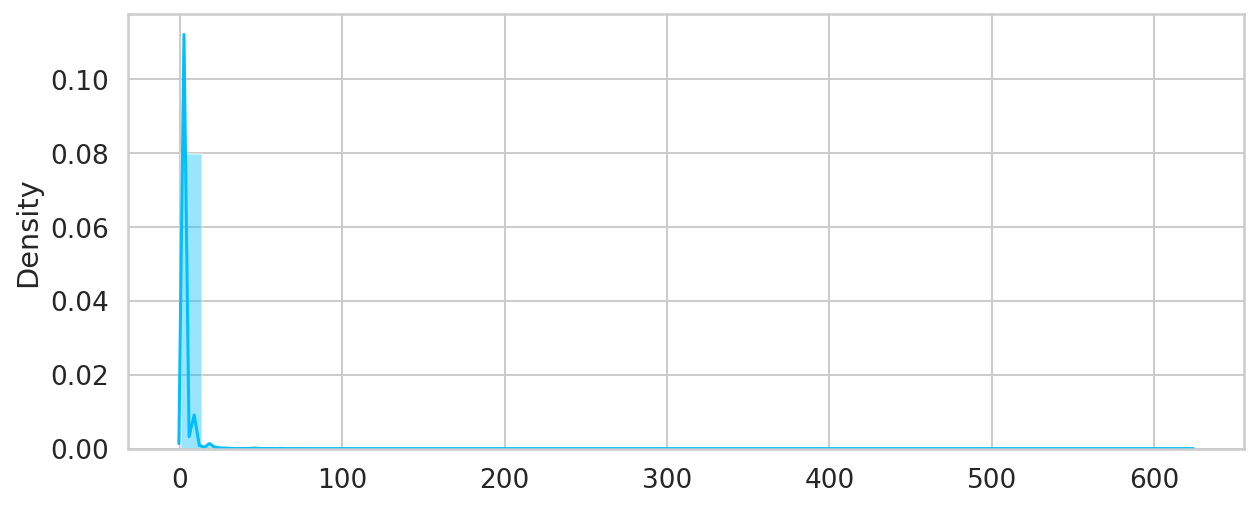

In [113]:
sns.distplot(losses, bins=50, kde=True);

In [151]:
def tune_threshold(model, criterion, df_all, device, b1, b2, a, print_report = True, disable=False):
    all_data = TensorDataset(torch.tensor(df_all.iloc[:,:-1].to_numpy()), torch.tensor(df_all.Type_Groups.to_numpy()))
    all_sampler = SequentialSampler(all_data)
    all_dataloader = DataLoader(all_data, sampler=all_sampler, batch_size=1)
    max_f1 = 0
    f1s = []
    accs = []
    thrs = np.arange(b1, b2, a).tolist() # a binary search would be more efficient :d
    total = len(all_dataloader) * len(thrs)
    with tqdm(total = total, disable=disable) as ee:
        for threshold in thrs:
            preds = []
            targets = []
            with torch.no_grad():
                for step, batch in enumerate(all_dataloader):
                    model.eval()
                    b_inputs, b_targets = tuple(t.to(device) for t in batch)
                    out = model.forward(b_inputs.float())
                    
                    loss = criterion(out, b_inputs)

                    targets.append(b_targets.item())

                    if loss> threshold:
                        preds.append(1)
                    else:
                        preds.append(0)
                    ee.update()
            f1s.append(f1_score(targets, preds, average = "macro"))
            accs.append(accuracy_score(targets, preds))
            if f1s[-1] > max_f1:
                max_f1 = f1s[-1]
                th_ret = threshold
                print(f"max f1: {max_f1}, threshold = {th_ret}")

    return accs, f1s, th_ret, thrs

In [148]:
# interpolating threshold space on validation set
accs, f1s, th_ret, thrs = tune_threshold(best_model, criterion, kdd_valid_probe, device, 5, 25, 0.50, print_report = True)

  0%|          | 0/800000 [00:00<?, ?it/s]

max f1: 0.9058086580265727, threshold = 5.0
max f1: 0.9096330972570876, threshold = 5.5
max f1: 0.9131161702564369, threshold = 9.0
max f1: 0.9187124176366714, threshold = 9.5
max f1: 0.9206374239314795, threshold = 10.0


In [152]:
accs, f1s, th_ret, thrs = tune_threshold(best_model, criterion, kdd_valid_probe, device, 10, 12, 0.05, print_report = True)

  0%|          | 0/800000 [00:00<?, ?it/s]

max f1: 0.9206374239314795, threshold = 10.0


In [149]:
def torch_classification_report(model, criterion, df_all, device, threshold, print_report = True, disable=False):
    all_data = TensorDataset(torch.tensor(df_all.iloc[:,:-1].to_numpy()), torch.tensor(df_all.Type_Groups.to_numpy()))
    all_sampler = SequentialSampler(all_data)
    all_dataloader = DataLoader(all_data, sampler=all_sampler, batch_size=1)
    total = len(all_dataloader)
    preds = []
    targets = []

    with tqdm(total = total, disable=disable) as ee:
        with torch.no_grad():
            for step, batch in enumerate(all_dataloader):
                model.eval()
                b_inputs, b_targets = tuple(t.to(device) for t in batch)
                out = model.forward(b_inputs.float())
                
                loss = criterion(out, b_inputs)

                targets.append(b_targets.item())

                if loss> threshold:
                    preds.append(1)
                else:
                    preds.append(0)
                ee.update()

    f1 = f1_score(targets, preds)
    acc = accuracy_score(targets, preds)
    if print_report:
        print(classification_report(targets, preds))
    return acc, f1

In [150]:
# choose best threshold on validation set and find f1 macro on test set (95% is actually very good)
acc, f1 = torch_classification_report(best_model, criterion, kdd_test_v2_probe, device, 10.0, print_report = True, disable=False)

  0%|          | 0/44758 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     41836
           1       0.84      0.99      0.91      2922

    accuracy                           0.99     44758
   macro avg       0.92      0.99      0.95     44758
weighted avg       0.99      0.99      0.99     44758



# DAE

In [165]:
# Danoising autoencoder implementation in PyTorch
class DAE(nn.Module):
    def __init__(self, n_features, latent_dim):
        super(DAE, self).__init__()
        self.n_features = n_features

        self.encoder = nn.Sequential(
            nn.Linear(n_features, 20),
            nn.Tanh(),
            nn.Linear(20, latent_dim),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 20),
            nn.ReLU(),
            nn.Linear(20, n_features)
        )
    
    def forward(self, x, device):
        bs = x.size(0)
        out = self.noise_mapping(x, device)
        out = self.encoder(x)
        out = self.decoder(out)
        return out

    def noise_mapping(self, x, device):
        noise = torch.randn(x.size(0), self.n_features).to(device)
        return x + noise

In [167]:
def evaluate(model, criterion, val_dataloader, device):
    total = len(val_dataloader)
    print("Evaluating...")
    loss_a = []
    with tqdm(total = total, leave=False) as ee:
        val_loss, val_batch_loss, val_batch_counts = 0, 0, 0
        for step, batch in enumerate(val_dataloader):
            model.eval()
            val_batch_loss += 1
            b_inputs, = tuple(t.to(device) for t in batch)
      
            with torch.no_grad():
                out = model.forward(b_inputs, device)
            
            loss = criterion(out, b_inputs)
            loss_a.append(loss.detach().cpu().numpy())

            ee.update()
    return np.mean(loss_a)

In [168]:
def train(model, optimizer, criterion, train_dataloader, val_dataloader, device, EPOCHS):
    model = model.to(device)
    total = len(train_dataloader) * EPOCHS
    log = defaultdict(list)
    log["train_loss"] = []
    log["eval_loss"] = []
    loss_a = []

    with tqdm(total = total) as tt:
        for epoch in range(EPOCHS):
            kl, nll, total_loss, batch_loss, batch_counts = 0, 0, 0, 0, 0
            for step, batch in enumerate(train_dataloader):
                model.train()
                batch_counts +=1

                b_inputs, = tuple(t.to(device) for t in batch)
                optimizer.zero_grad()

                out = model(b_inputs, device)

                loss = criterion(out, b_inputs)
                loss.backward()

                optimizer.step()

                batch_loss += loss.item()
                total_loss += loss.item()
                #loss_a.append(loss.detach().cpu().numpy())
                tt.update()

            val_loss = evaluate(model, criterion, val_dataloader, device)
            print(30*"-")
            print(f"{epoch+1}/{EPOCHS}")
            print(f"train loss: {batch_loss / batch_counts}, val loss: {val_loss}")
            log["train_loss"].append(batch_loss / batch_counts)
            log["eval_loss"].append(val_loss)
            
            if log["eval_loss"][np.argmin(log["eval_loss"])] == val_loss:
                print(f"Best model is stored with eval loss {val_loss}.")
                best_model = model
            print(30*"-")
    return model, best_model, log

In [169]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DAE(train_normal.shape[1] - 1, 10)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

criterion = torch.nn.MSELoss(reduction="sum")
EPOCHS = 125

# you can optimize the learning rate, or the optimizer in general
# it is not a willful loss function decision, you can choose more proper loss function
# for you dataset (depends on your dataset's characteristics)
# reduction="sum" parameter can be "mean". I like large gradient magnitudes lol

# i think L1 loss is better than MSE loss for this dataset

In [170]:
model, best_model, log = train(
    model, 
    optimizer, 
    criterion, 
    train_dataloader, 
    val_dataloader, 
    device, 
    EPOCHS
)

  0%|          | 0/95000 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
1/125
train loss: 1915.4008703131424, val loss: 2439.11328125
Best model is stored with eval loss 2439.11328125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
2/125
train loss: 1357.636915457876, val loss: 2282.8681640625
Best model is stored with eval loss 2282.8681640625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
3/125
train loss: 1191.1473478919581, val loss: 2189.505859375
Best model is stored with eval loss 2189.505859375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
4/125
train loss: 1099.0691940307618, val loss: 2138.896728515625
Best model is stored with eval loss 2138.896728515625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
5/125
train loss: 1049.0468477700886, val loss: 2110.482666015625
Best model is stored with eval loss 2110.482666015625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
6/125
train loss: 1013.7509181675158, val loss: 2097.22607421875
Best model is stored with eval loss 2097.22607421875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
7/125
train loss: 982.4922679198415, val loss: 2080.894775390625
Best model is stored with eval loss 2080.894775390625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
8/125
train loss: 952.9532039341174, val loss: 2070.4501953125
Best model is stored with eval loss 2070.4501953125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
9/125
train loss: 927.0546641349792, val loss: 2062.70849609375
Best model is stored with eval loss 2062.70849609375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
10/125
train loss: 905.0988133781834, val loss: 2051.4326171875
Best model is stored with eval loss 2051.4326171875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
11/125
train loss: 885.236378182863, val loss: 2040.25634765625
Best model is stored with eval loss 2040.25634765625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
12/125
train loss: 869.0365938337226, val loss: 2039.19091796875
Best model is stored with eval loss 2039.19091796875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
13/125
train loss: 854.8546405792237, val loss: 2022.5091552734375
Best model is stored with eval loss 2022.5091552734375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
14/125
train loss: 843.5233078103316, val loss: 2019.7757568359375
Best model is stored with eval loss 2019.7757568359375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
15/125
train loss: 831.6377994286387, val loss: 2002.519775390625
Best model is stored with eval loss 2002.519775390625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
16/125
train loss: 821.7937001579686, val loss: 1990.092529296875
Best model is stored with eval loss 1990.092529296875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
17/125
train loss: 810.801677698838, val loss: 1976.2872314453125
Best model is stored with eval loss 1976.2872314453125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
18/125
train loss: 801.5520678018269, val loss: 1971.548095703125
Best model is stored with eval loss 1971.548095703125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
19/125
train loss: 792.2393661348443, val loss: 1955.7861328125
Best model is stored with eval loss 1955.7861328125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
20/125
train loss: 782.7171925293771, val loss: 1946.8819580078125
Best model is stored with eval loss 1946.8819580078125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
21/125
train loss: 772.1488433185376, val loss: 1932.9810791015625
Best model is stored with eval loss 1932.9810791015625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
22/125
train loss: 762.0198969037909, val loss: 1921.464111328125
Best model is stored with eval loss 1921.464111328125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
23/125
train loss: 752.8719350162305, val loss: 1903.92138671875
Best model is stored with eval loss 1903.92138671875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
24/125
train loss: 742.7302410778246, val loss: 1880.7999267578125
Best model is stored with eval loss 1880.7999267578125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
25/125
train loss: 731.1283046772605, val loss: 1863.3885498046875
Best model is stored with eval loss 1863.3885498046875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
26/125
train loss: 719.983444655569, val loss: 1846.8529052734375
Best model is stored with eval loss 1846.8529052734375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
27/125
train loss: 709.7177320580734, val loss: 1827.4647216796875
Best model is stored with eval loss 1827.4647216796875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
28/125
train loss: 696.7465925342158, val loss: 1828.8153076171875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
29/125
train loss: 689.9759987379375, val loss: 1803.6622314453125
Best model is stored with eval loss 1803.6622314453125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
30/125
train loss: 678.4139882162998, val loss: 1796.380126953125
Best model is stored with eval loss 1796.380126953125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
31/125
train loss: 669.4141891128138, val loss: 1794.523193359375
Best model is stored with eval loss 1794.523193359375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
32/125
train loss: 653.4638483122775, val loss: 1768.00830078125
Best model is stored with eval loss 1768.00830078125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
33/125
train loss: 645.1441493862553, val loss: 1753.1319580078125
Best model is stored with eval loss 1753.1319580078125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
34/125
train loss: 634.0851281793495, val loss: 1756.780029296875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
35/125
train loss: 623.8446986700359, val loss: 1749.877685546875
Best model is stored with eval loss 1749.877685546875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
36/125
train loss: 615.4161080561186, val loss: 1735.3778076171875
Best model is stored with eval loss 1735.3778076171875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
37/125
train loss: 610.2520115149648, val loss: 1687.4052734375
Best model is stored with eval loss 1687.4052734375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
38/125
train loss: 597.8552334810558, val loss: 1661.3836669921875
Best model is stored with eval loss 1661.3836669921875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
39/125
train loss: 589.6277612836737, val loss: 1648.977294921875
Best model is stored with eval loss 1648.977294921875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
40/125
train loss: 581.0303425035978, val loss: 1670.1739501953125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
41/125
train loss: 573.1119099717391, val loss: 1641.0816650390625
Best model is stored with eval loss 1641.0816650390625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
42/125
train loss: 565.8152784598501, val loss: 1631.90185546875
Best model is stored with eval loss 1631.90185546875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
43/125
train loss: 559.737578929098, val loss: 1612.824951171875
Best model is stored with eval loss 1612.824951171875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
44/125
train loss: 549.6196686067079, val loss: 1635.440673828125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
45/125
train loss: 544.923338257639, val loss: 1570.27197265625
Best model is stored with eval loss 1570.27197265625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
46/125
train loss: 541.3038126142402, val loss: 1540.60498046875
Best model is stored with eval loss 1540.60498046875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
47/125
train loss: 529.4345963227122, val loss: 1531.6279296875
Best model is stored with eval loss 1531.6279296875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
48/125
train loss: 521.9504728969774, val loss: 1513.9305419921875
Best model is stored with eval loss 1513.9305419921875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
49/125
train loss: 518.2210662314766, val loss: 1504.674560546875
Best model is stored with eval loss 1504.674560546875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
50/125
train loss: 510.6008689855274, val loss: 1501.8623046875
Best model is stored with eval loss 1501.8623046875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
51/125
train loss: 504.7078721096641, val loss: 1473.58642578125
Best model is stored with eval loss 1473.58642578125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
52/125
train loss: 500.7573910085778, val loss: 1508.1048583984375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
53/125
train loss: 496.3290104665254, val loss: 1462.4547119140625
Best model is stored with eval loss 1462.4547119140625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
54/125
train loss: 489.3746385222987, val loss: 1471.4547119140625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
55/125
train loss: 482.4115766977009, val loss: 1483.3773193359375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
56/125
train loss: 477.15185925835056, val loss: 1467.1260986328125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
57/125
train loss: 470.74972238540647, val loss: 1454.584716796875
Best model is stored with eval loss 1454.584716796875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
58/125
train loss: 466.48878741013374, val loss: 1421.1627197265625
Best model is stored with eval loss 1421.1627197265625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
59/125
train loss: 462.2989198684692, val loss: 1490.1483154296875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
60/125
train loss: 453.5360631114558, val loss: 1421.7166748046875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
61/125
train loss: 450.5400390374033, val loss: 1382.4276123046875
Best model is stored with eval loss 1382.4276123046875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
62/125
train loss: 449.39880483275965, val loss: 1390.110595703125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
63/125
train loss: 449.5590513480337, val loss: 1344.5107421875
Best model is stored with eval loss 1344.5107421875.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
64/125
train loss: 436.4558833021867, val loss: 1340.8734130859375
Best model is stored with eval loss 1340.8734130859375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
65/125
train loss: 435.2248895770625, val loss: 1340.027587890625
Best model is stored with eval loss 1340.027587890625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
66/125
train loss: 425.4289674106397, val loss: 1331.94580078125
Best model is stored with eval loss 1331.94580078125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
67/125
train loss: 421.97899448997094, val loss: 1286.956787109375
Best model is stored with eval loss 1286.956787109375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
68/125
train loss: 420.0422199901782, val loss: 1347.9615478515625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
69/125
train loss: 414.8228010930513, val loss: 1440.5439453125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
70/125
train loss: 409.00199021791155, val loss: 1298.357421875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
71/125
train loss: 409.0873585650795, val loss: 1295.951904296875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
72/125
train loss: 398.9794910581488, val loss: 1308.83740234375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
73/125
train loss: 395.6571094864293, val loss: 1301.39990234375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
74/125
train loss: 391.30935329638027, val loss: 1287.715087890625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
75/125
train loss: 389.6497958961286, val loss: 1299.6942138671875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
76/125
train loss: 390.93129225279154, val loss: 1258.386962890625
Best model is stored with eval loss 1258.386962890625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
77/125
train loss: 389.8644488535429, val loss: 1319.4281005859375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
78/125
train loss: 382.61490435349316, val loss: 1237.417236328125
Best model is stored with eval loss 1237.417236328125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
79/125
train loss: 377.10741615797343, val loss: 1361.957763671875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
80/125
train loss: 377.2230680566085, val loss: 1405.2939453125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
81/125
train loss: 375.3401366233826, val loss: 1347.6158447265625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
82/125
train loss: 371.1471403975236, val loss: 1381.89111328125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
83/125
train loss: 367.17451000715556, val loss: 1297.0455322265625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
84/125
train loss: 367.06595190449764, val loss: 1417.5369873046875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
85/125
train loss: 361.18325399599576, val loss: 1329.632080078125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
86/125
train loss: 363.38200759887695, val loss: 1238.72412109375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
87/125
train loss: 353.5437528811003, val loss: 1245.3956298828125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
88/125
train loss: 355.12019108722086, val loss: 1245.88427734375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
89/125
train loss: 353.23557411495005, val loss: 1247.4683837890625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
90/125
train loss: 349.94869734111586, val loss: 1278.35400390625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
91/125
train loss: 346.08735458976344, val loss: 1289.9268798828125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
92/125
train loss: 347.00524762304207, val loss: 1265.41259765625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
93/125
train loss: 346.15987746590065, val loss: 1288.1959228515625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
94/125
train loss: 345.28902112057335, val loss: 1323.4197998046875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
95/125
train loss: 346.7288465098331, val loss: 1114.7008056640625
Best model is stored with eval loss 1114.7008056640625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
96/125
train loss: 342.4111172625893, val loss: 1349.360595703125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
97/125
train loss: 338.16098911385785, val loss: 1320.0943603515625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
98/125
train loss: 339.73207726729544, val loss: 1424.1285400390625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
99/125
train loss: 339.2804557047392, val loss: 1245.34130859375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
100/125
train loss: 336.9030809402466, val loss: 1171.5391845703125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
101/125
train loss: 351.6554910258243, val loss: 1339.3577880859375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
102/125
train loss: 334.26065134249234, val loss: 1307.053466796875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
103/125
train loss: 334.82563998824673, val loss: 1268.40380859375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
104/125
train loss: 330.28048387828625, val loss: 1310.780517578125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
105/125
train loss: 331.2940700681586, val loss: 1270.6893310546875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
106/125
train loss: 334.89556973858885, val loss: 1317.4827880859375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
107/125
train loss: 329.56302129594906, val loss: 1308.99462890625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
108/125
train loss: 327.751941158897, val loss: 1304.6260986328125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
109/125
train loss: 323.7775298595428, val loss: 1266.605224609375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
110/125
train loss: 325.5729867207377, val loss: 1381.013427734375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
111/125
train loss: 325.94892930984497, val loss: 1281.2532958984375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
112/125
train loss: 326.58161542290134, val loss: 1264.6385498046875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
113/125
train loss: 340.99398649366276, val loss: 1207.1695556640625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
114/125
train loss: 327.42629808626674, val loss: 1277.837646484375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
115/125
train loss: 322.9126996391698, val loss: 1315.5230712890625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
116/125
train loss: 322.473248280977, val loss: 1407.2479248046875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
117/125
train loss: 325.564159526323, val loss: 1344.1041259765625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
118/125
train loss: 318.64468524079575, val loss: 1342.658447265625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
119/125
train loss: 325.8149829161795, val loss: 1447.68359375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
120/125
train loss: 317.88432645295796, val loss: 1227.1204833984375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
121/125
train loss: 315.31645022442467, val loss: 1232.01123046875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
122/125
train loss: 319.81552807155407, val loss: 1203.798583984375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
123/125
train loss: 320.5305186522634, val loss: 1378.5357666015625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
124/125
train loss: 316.00888253262167, val loss: 1397.088623046875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
125/125
train loss: 316.3246353299994, val loss: 1372.3446044921875
------------------------------


In [171]:
def thresholding(model, criterion, dataset, device):
    preds, losses = [], []
    total = len(dataset)

    val_data = TensorDataset(torch.Tensor(dataset.iloc[:,:-1].to_numpy()))
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=1)
    with tqdm(total = total) as ee:
        with torch.no_grad():
            for step, batch in enumerate(val_dataloader):
                model.eval()
                b_inputs, = tuple(t.to(device) for t in batch)
                out = model(b_inputs, device)

                loss = criterion(out, b_inputs)

                preds.append([out.detach().cpu().numpy(), b_inputs.cpu().numpy()])
                losses.append(loss.detach().cpu().numpy())
                ee.update()
            ee.close()

    return preds, losses

In [172]:
reconstructions, losses = thresholding(best_model, criterion, test_normal, device)

  0%|          | 0/41836 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


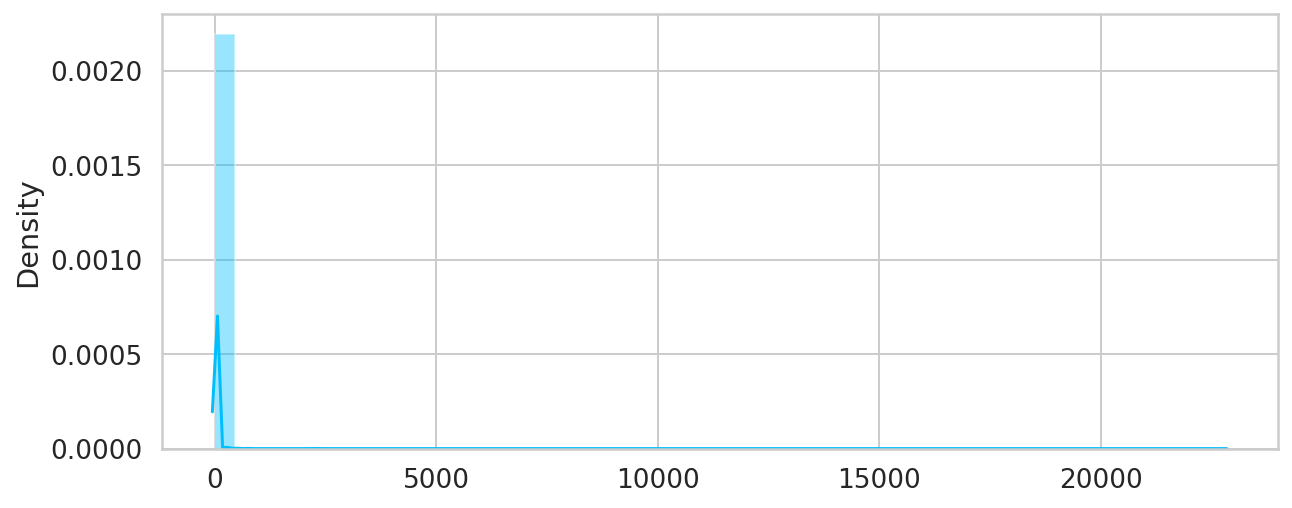

In [173]:
sns.distplot(losses, bins=50, kde=True);

In [179]:
def tune_threshold(model, criterion, df_all, device, b1, b2, a, print_report = True, disable=False):
    all_data = TensorDataset(torch.tensor(df_all.iloc[:,:-1].to_numpy()), torch.tensor(df_all.Type_Groups.to_numpy()))
    all_sampler = SequentialSampler(all_data)
    all_dataloader = DataLoader(all_data, sampler=all_sampler, batch_size=1)
    max_f1 = 0
    f1s = []
    accs = []
    thrs = np.arange(b1, b2, a).tolist() # a binary search would be more efficient :d
    total = len(all_dataloader) * len(thrs)
    with tqdm(total = total, disable=disable) as ee:
        for threshold in thrs:
            preds = []
            targets = []
            with torch.no_grad():
                for step, batch in enumerate(all_dataloader):
                    model.eval()
                    b_inputs, b_targets = tuple(t.to(device) for t in batch)
                    out = model(b_inputs.float(), device)
                    
                    loss = criterion(out, b_inputs)

                    targets.append(b_targets.item())

                    if loss> threshold:
                        preds.append(1)
                    else:
                        preds.append(0)
                    ee.update()
            f1s.append(f1_score(targets, preds, average = "macro"))
            accs.append(accuracy_score(targets, preds))
            if f1s[-1] > max_f1:
                max_f1 = f1s[-1]
                th_ret = threshold
                print(f"max f1: {max_f1}, threshold = {th_ret}")

    return accs, f1s, th_ret, thrs

In [181]:
# interpolating threshold space on validation set
accs, f1s, th_ret, thrs = tune_threshold(best_model, criterion, kdd_valid_probe, device, 5, 25, 0.50, print_report = True)

  0%|          | 0/800000 [00:00<?, ?it/s]

max f1: 0.9117550132812815, threshold = 5.0
max f1: 0.9187347588246166, threshold = 5.5
max f1: 0.9259790255635956, threshold = 6.0
max f1: 0.9292891524754213, threshold = 6.5
max f1: 0.9302608459311622, threshold = 7.0


In [182]:
# interpolating threshold space on validation set
# i did something like a binary search but i didnt implemented it. YES I DID IT BY HAND.
accs, f1s, th_ret, thrs = tune_threshold(best_model, criterion, kdd_valid_probe, device, 6.50, 7.50, 0.03, print_report = True)

  0%|          | 0/680000 [00:00<?, ?it/s]

max f1: 0.9292891524754213, threshold = 6.5
max f1: 0.9294557751996771, threshold = 6.53
max f1: 0.929622505076309, threshold = 6.590000000000001
max f1: 0.9297893422194978, threshold = 6.620000000000001
max f1: 0.9302904983926403, threshold = 6.650000000000001
max f1: 0.9305798308219065, threshold = 6.710000000000002
max f1: 0.9307474059576408, threshold = 6.770000000000002
max f1: 0.9307521673684436, threshold = 7.2800000000000065


In [185]:
def torch_classification_report(model, criterion, df_all, device, threshold, print_report = True, disable=False):
    all_data = TensorDataset(torch.tensor(df_all.iloc[:,:-1].to_numpy()), torch.tensor(df_all.Type_Groups.to_numpy()))
    all_sampler = SequentialSampler(all_data)
    all_dataloader = DataLoader(all_data, sampler=all_sampler, batch_size=1)
    total = len(all_dataloader)
    preds = []
    targets = []

    with tqdm(total = total, disable=disable) as ee:
        with torch.no_grad():
            for step, batch in enumerate(all_dataloader):
                model.eval()
                b_inputs, b_targets = tuple(t.to(device) for t in batch)
                out = model(b_inputs.float(), device)
                
                loss = criterion(out, b_inputs)

                targets.append(b_targets.item())

                if loss> threshold:
                    preds.append(1)
                else:
                    preds.append(0)
                ee.update()

    f1 = f1_score(targets, preds, average = "macro")
    acc = accuracy_score(targets, preds)
    if print_report:
        print(classification_report(targets, preds))
    return acc, f1

In [186]:
# choose best threshold on validation set and find f1 macro on test set
acc, f1 = torch_classification_report(best_model, criterion, kdd_test_v2_probe, device, 7.2800000000000065, print_report = True, disable=False)

  0%|          | 0/44758 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     41836
           1       0.68      1.00      0.81      2922

    accuracy                           0.97     44758
   macro avg       0.84      0.98      0.90     44758
weighted avg       0.98      0.97      0.97     44758



# Ensemble AE

In [216]:
# ensembling 2 autoencoder, first one is initialized with xavier uniform
# the latter is initialized with kaiming normal

def weights_init1(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)


def weights_init2(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)


class VanillaAE(nn.Module):
    def __init__(self, n_features, latent_dim):
        super(VanillaAE, self).__init__()
        self.n_features = n_features

        self.encoder = nn.Sequential(
            nn.Linear(n_features, 20),
            nn.Tanh(),
            nn.Linear(20, latent_dim),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 20),
            nn.ReLU(),
            nn.Linear(20, n_features)
        )
    
    def forward(self, x):
        bs = x.size(0)
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [217]:
def evaluate(model1, model2, criterion, val_dataloader, device):
    total = len(val_dataloader)
    print("Evaluating...")
    loss_a = []
    with tqdm(total = total, leave=False) as ee:
        val_loss, val_batch_loss, val_batch_counts = 0, 0, 0
        for step, batch in enumerate(val_dataloader):
            model1.eval()
            model2.eval()

            val_batch_loss += 1
            b_inputs, = tuple(t.to(device) for t in batch)
      
            with torch.no_grad():
                out1 = model1(b_inputs)
                out2 = model2(b_inputs)
                out = (out1 + out2) / 2
            
            loss = criterion(out, b_inputs)
            loss_a.append(loss.detach().cpu().numpy())

            ee.update()
    return np.mean(loss_a)

In [218]:
def train(model1, model2, optimizer1, optimizer2, criterion, train_dataloader, val_dataloader, device, EPOCHS):
    model1 = model1.to(device)
    model2 = model2.to(device)

    total = len(train_dataloader) * EPOCHS
    log = defaultdict(list)
    log["train_loss"] = []
    log["eval_loss"] = []
    loss_a = []

    with tqdm(total = total) as tt:
        for epoch in range(EPOCHS):
            kl, nll, total_loss, batch_loss, batch_counts = 0, 0, 0, 0, 0
            for step, batch in enumerate(train_dataloader):
                model1.train()
                model2.train()

                batch_counts +=1

                b_inputs, = tuple(t.to(device) for t in batch)

                optimizer1.zero_grad()
                optimizer2.zero_grad()

                out1 = model1(b_inputs)
                out2 = model2(b_inputs)
                out = (out1 + out2) / 2

                loss = criterion(out, b_inputs)
                loss.backward()

                optimizer1.step()
                optimizer2.step()

                batch_loss += loss.item()
                total_loss += loss.item()
                #loss_a.append(loss.detach().cpu().numpy())
                tt.update()

            val_loss = evaluate(model1, model2, criterion, val_dataloader, device)
            print(30*"-")
            print(f"{epoch+1}/{EPOCHS}")
            print(f"train loss: {batch_loss / batch_counts}, val loss: {val_loss}")
            log["train_loss"].append(batch_loss / batch_counts)
            log["eval_loss"].append(val_loss)
            
            if log["eval_loss"][np.argmin(log["eval_loss"])] == val_loss:
                print(f"Best model is stored with eval loss {val_loss}.")
                best_model1 = model1
                best_model2 = model2
            print(30*"-")
    return best_model1, best_model2, log

In [221]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = VanillaAE(train_normal.shape[1] - 1, 10)
model1.apply(weights_init1)

model2 = VanillaAE(train_normal.shape[1] - 1, 10)
model2.apply(weights_init2)


optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.0005, weight_decay=1e-5)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.005, weight_decay=1e-5)

criterion = torch.nn.L1Loss(reduction="sum")
EPOCHS = 40

In [222]:
best_model1, best_model2, log  = train(
    model1, 
    model2, 
    optimizer1, 
    optimizer2, 
    criterion, 
    train_dataloader, 
    val_dataloader, 
    device, 
    EPOCHS
)

  0%|          | 0/30400 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
1/40
train loss: 444.8908738989579, val loss: 447.28704833984375
Best model is stored with eval loss 447.28704833984375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
2/40
train loss: 259.55480357722234, val loss: 305.4600524902344
Best model is stored with eval loss 305.4600524902344.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
3/40
train loss: 177.99506563889352, val loss: 291.7124938964844
Best model is stored with eval loss 291.7124938964844.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
4/40
train loss: 158.0803873865228, val loss: 258.2079772949219
Best model is stored with eval loss 258.2079772949219.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
5/40
train loss: 142.6001745223999, val loss: 245.38111877441406
Best model is stored with eval loss 245.38111877441406.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
6/40
train loss: 133.33073598460146, val loss: 226.04783630371094
Best model is stored with eval loss 226.04783630371094.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
7/40
train loss: 126.23885371559544, val loss: 228.24952697753906
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
8/40
train loss: 121.30683425100226, val loss: 231.45950317382812
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
9/40
train loss: 116.99406675539518, val loss: 221.95050048828125
Best model is stored with eval loss 221.95050048828125.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
10/40
train loss: 114.84412547161705, val loss: 220.99075317382812
Best model is stored with eval loss 220.99075317382812.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
11/40
train loss: 112.14772114000823, val loss: 214.84375
Best model is stored with eval loss 214.84375.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
12/40
train loss: 110.45899396695589, val loss: 221.5880126953125
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
13/40
train loss: 108.69765019667776, val loss: 205.84625244140625
Best model is stored with eval loss 205.84625244140625.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
14/40
train loss: 107.79484704168219, val loss: 209.0166015625
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
15/40
train loss: 106.40968684146279, val loss: 212.24465942382812
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
16/40
train loss: 104.37530419701024, val loss: 208.65696716308594
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
17/40
train loss: 96.71017815439325, val loss: 207.98989868164062
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
18/40
train loss: 92.73649611222116, val loss: 204.82774353027344
Best model is stored with eval loss 204.82774353027344.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
19/40
train loss: 91.63551375740452, val loss: 202.6483917236328
Best model is stored with eval loss 202.6483917236328.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
20/40
train loss: 90.93463025344046, val loss: 204.7218780517578
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
21/40
train loss: 90.28600561242355, val loss: 201.51510620117188
Best model is stored with eval loss 201.51510620117188.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
22/40
train loss: 89.48642650905408, val loss: 207.49868774414062
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
23/40
train loss: 89.40296024523283, val loss: 207.18911743164062
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
24/40
train loss: 88.72862549079092, val loss: 207.88059997558594
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
25/40
train loss: 88.36634119435361, val loss: 207.9318084716797
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
26/40
train loss: 87.53693790435791, val loss: 207.5568084716797
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
27/40
train loss: 87.56365479670073, val loss: 207.40101623535156
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
28/40
train loss: 86.68714605883548, val loss: 205.2134552001953
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
29/40
train loss: 86.15909392457259, val loss: 209.09901428222656
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
30/40
train loss: 85.82279838009885, val loss: 207.5891571044922
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
31/40
train loss: 84.98724785353008, val loss: 205.29666137695312
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
32/40
train loss: 84.57661459822404, val loss: 201.89105224609375
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
33/40
train loss: 83.98188172139619, val loss: 201.83743286132812
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
34/40
train loss: 83.39077391373483, val loss: 208.0032501220703
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
35/40
train loss: 82.33185784440292, val loss: 204.24850463867188
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
36/40
train loss: 81.10351216918544, val loss: 208.7990264892578
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
37/40
train loss: 80.27150512243573, val loss: 204.74334716796875
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
38/40
train loss: 78.30849578004134, val loss: 201.39443969726562
Best model is stored with eval loss 201.39443969726562.
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
39/40
train loss: 77.48775430478548, val loss: 205.1460418701172
------------------------------
Evaluating...


  0%|          | 0/147 [00:00<?, ?it/s]

------------------------------
40/40
train loss: 76.87890778340791, val loss: 206.1577606201172
------------------------------


In [225]:
def thresholding(model1, model2, criterion, dataset, device):
    preds, losses = [], []
    total = len(dataset)

    val_data = TensorDataset(torch.Tensor(dataset.iloc[:,:-1].to_numpy()))
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=1)
    with tqdm(total = total) as ee:
        with torch.no_grad():
            for step, batch in enumerate(val_dataloader):
                model1.eval()
                model2.eval()
                b_inputs, = tuple(t.to(device) for t in batch)
                out1 = model1(b_inputs)
                out2 = model1(b_inputs)
                out = (out1 + out2) / 2

                loss = criterion(out, b_inputs)

                preds.append([out.detach().cpu().numpy(), b_inputs.cpu().numpy()])
                losses.append(loss.detach().cpu().numpy())
                ee.update()
            ee.close()

    return preds, losses

In [226]:
reconstructions, losses = thresholding(best_model1, best_model2, criterion, test_normal, device)
print(np.mean(losses))

  0%|          | 0/41836 [00:00<?, ?it/s]

7.05118


In [223]:
def tune_threshold(model1, model2, criterion, df_all, device, b1, b2, a, print_report = True, disable=False):
    all_data = TensorDataset(torch.tensor(df_all.iloc[:,:-1].to_numpy()), torch.tensor(df_all.Type_Groups.to_numpy()))
    all_sampler = SequentialSampler(all_data)
    all_dataloader = DataLoader(all_data, sampler=all_sampler, batch_size=1)
    max_f1 = 0
    f1s = []
    accs = []
    thrs = np.arange(b1, b2, a).tolist() # a binary search would be more efficient :d
    total = len(all_dataloader) * len(thrs)
    with tqdm(total = total, disable=disable) as ee:
        for threshold in thrs:
            preds = []
            targets = []
            with torch.no_grad():
                for step, batch in enumerate(all_dataloader):
                    model1.eval()
                    model2.eval()

                    b_inputs, b_targets = tuple(t.to(device) for t in batch)

                    out1 = model1(b_inputs.float())
                    out2 = model2(b_inputs.float())
                    out = (out1 + out2) / 2
                    
                    loss = criterion(out, b_inputs)

                    targets.append(b_targets.item())

                    if loss> threshold:
                        preds.append(1)
                    else:
                        preds.append(0)
                    ee.update()
            f1s.append(f1_score(targets, preds, average = "macro"))
            accs.append(accuracy_score(targets, preds))
            if f1s[-1] > max_f1:
                max_f1 = f1s[-1]
                th_ret = threshold
                print(f"max f1: {max_f1}, threshold = {th_ret}")

    return accs, f1s, th_ret, thrs

In [234]:
accs, f1s, th_ret, thrs = tune_threshold(best_model1, best_model2, criterion, kdd_valid_probe, device, 9, 10.5, 0.2, print_report = True)

  0%|          | 0/160000 [00:00<?, ?it/s]

max f1: 0.8810190173199088, threshold = 9.0


In [231]:
def torch_classification_report(model1, model2, criterion, df_all, device, threshold, print_report = True, disable=False):
    all_data = TensorDataset(torch.tensor(df_all.iloc[:,:-1].to_numpy()), torch.tensor(df_all.Type_Groups.to_numpy()))
    all_sampler = SequentialSampler(all_data)
    all_dataloader = DataLoader(all_data, sampler=all_sampler, batch_size=1)
    total = len(all_dataloader)
    preds = []
    targets = []

    with tqdm(total = total, disable=disable) as ee:
        with torch.no_grad():
            for step, batch in enumerate(all_dataloader):
                model1.eval()
                model2.eval()
                b_inputs, b_targets = tuple(t.to(device) for t in batch)

                out1 = model1(b_inputs.float())
                out2 = model2(b_inputs.float())

                out = (out1 + out2) / 2
                
                loss = criterion(out, b_inputs)

                targets.append(b_targets.item())

                if loss> threshold:
                    preds.append(1)
                else:
                    preds.append(0)
                ee.update()

    f1 = f1_score(targets, preds)
    acc = accuracy_score(targets, preds)
    if print_report:
        print(classification_report(targets, preds))
    return acc, f1

In [237]:
# 93% is nice. I think ensemble model overfits train set
acc, f1 = torch_classification_report(best_model1, best_model2, criterion, kdd_test_v2_probe, device,10 , print_report = True, disable=False)

  0%|          | 0/44758 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     41836
           1       0.87      0.87      0.87      2922

    accuracy                           0.98     44758
   macro avg       0.93      0.93      0.93     44758
weighted avg       0.98      0.98      0.98     44758

